In [2]:
import os
import math
import pickle
import torch
import optuna
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# 获取所有图像路径，递归查找
data = glob(r'/root/autodl-tmp/fingerprints/fingerprints/DB*/**/*.tif', recursive=True)
images = []

# 读取图像
def readImages(data):
    for img_path in data:
        print(f"尝试读取图像: {img_path}")
        try:
            img = Image.open(img_path).convert("RGB").resize((224, 224))
            images.append(np.array(img))
        except Exception as e:
            print(f"无法读取图像: {img_path}，错误信息: {e}")
    return images

images = readImages(data)
if len(images) == 0:
    raise ValueError("没有成功读取任何图像，请检查文件路径和格式。")

# 预处理图像数据
images_arr = np.asarray(images).astype('float32') / 255.0
if len(images_arr.shape) == 4:
    images_arr = np.transpose(images_arr, (0, 3, 1, 2))
else:
    raise ValueError("图像数组的形状不正确，检查读取步骤。")

# 划分训练集和验证集
train_X, valid_X, train_ground, valid_ground = train_test_split(
    images_arr, images_arr, test_size=0.2, random_state=13
)

# 转换为PyTorch张量
train_X = torch.tensor(train_X, dtype=torch.float32)
valid_X = torch.tensor(valid_X, dtype=torch.float32)
train_ground = torch.tensor(train_ground, dtype=torch.float32)
valid_ground = torch.tensor(valid_ground, dtype=torch.float32)

# 创建数据加载器
train_loader = DataLoader(TensorDataset(train_X, train_ground), batch_size=128, shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_X, valid_ground), batch_size=128, shuffle=False)

尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_6.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_1.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_7.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_2.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_8.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_3.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_1.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_4.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_3.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_5.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_2.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_6.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_4.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_7.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_5

In [3]:
# 定义 CustomReLU 激活函数
class CustomReLU(nn.Module):
    def __init__(self, seqFlag, trial):
        super(CustomReLU, self).__init__()
        self.sigma = nn.Parameter(
            torch.tensor(trial.suggest_float(f'sigma_{seqFlag}', 0, 1), dtype=torch.float32)
        )

    def forward(self, x):
        return torch.max(x, self.sigma * x)

# 定义自动编码器模型
class Autoencoder(nn.Module):
    def __init__(self, trial):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), CustomReLU(1, trial), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, 1), CustomReLU(2, trial), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), CustomReLU(3, trial)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1), CustomReLU(4, trial), nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, 1, 1), CustomReLU(5, trial), nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 3, 3, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

# 使用GPU（如可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义训练函数
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=300):
    model.train()
    train_loss, valid_loss = [], []

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()

        valid_loss.append(val_loss / len(valid_loader))
        print(f"Epoch {epoch + 1}, Training Loss: {train_loss[-1]:.4f}, Validation Loss: {valid_loss[-1]:.4f}")

    return train_loss, valid_loss

# 定义Optuna目标函数
def objective(trial):
    model = Autoencoder(trial).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss, valid_loss = train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=300)
    return valid_loss[-1]

# 使用Optuna进行超参数优化
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# 获取最佳参数并重新训练模型
best_params = study.best_params
print("最佳参数: ", best_params)

[I 2024-10-14 17:36:09,367] A new study created in memory with name: no-name-18a9b67f-e95b-4dcc-ae24-5ef97ba013c6


Epoch 1, Training Loss: 0.0661, Validation Loss: 0.0483
Epoch 2, Training Loss: 0.0588, Validation Loss: 0.0441
Epoch 3, Training Loss: 0.0458, Validation Loss: 0.0559
Epoch 4, Training Loss: 0.0503, Validation Loss: 0.0402
Epoch 5, Training Loss: 0.0345, Validation Loss: 0.0320
Epoch 6, Training Loss: 0.0271, Validation Loss: 0.0263
Epoch 7, Training Loss: 0.0252, Validation Loss: 0.0210
Epoch 8, Training Loss: 0.0200, Validation Loss: 0.0223
Epoch 9, Training Loss: 0.0198, Validation Loss: 0.0210
Epoch 10, Training Loss: 0.0193, Validation Loss: 0.0213
Epoch 11, Training Loss: 0.0179, Validation Loss: 0.0177
Epoch 12, Training Loss: 0.0163, Validation Loss: 0.0192
Epoch 13, Training Loss: 0.0172, Validation Loss: 0.0186
Epoch 14, Training Loss: 0.0164, Validation Loss: 0.0174
Epoch 15, Training Loss: 0.0155, Validation Loss: 0.0178
Epoch 16, Training Loss: 0.0162, Validation Loss: 0.0178
Epoch 17, Training Loss: 0.0160, Validation Loss: 0.0173
Epoch 18, Training Loss: 0.0153, Validat

[I 2024-10-14 17:38:46,668] Trial 0 finished with value: 0.0031113598961383104 and parameters: {'sigma_1': 0.2933482395426924, 'sigma_2': 0.6549630838879448, 'sigma_3': 0.4159125274079949, 'sigma_4': 0.11377301076411384, 'sigma_5': 0.7706415605977803}. Best is trial 0 with value: 0.0031113598961383104.


Epoch 300, Training Loss: 0.0027, Validation Loss: 0.0031
Epoch 1, Training Loss: 0.0655, Validation Loss: 0.0710
Epoch 2, Training Loss: 0.0641, Validation Loss: 0.0648
Epoch 3, Training Loss: 0.0590, Validation Loss: 0.0515
Epoch 4, Training Loss: 0.0465, Validation Loss: 0.0421
Epoch 5, Training Loss: 0.0374, Validation Loss: 0.0371
Epoch 6, Training Loss: 0.0275, Validation Loss: 0.0268
Epoch 7, Training Loss: 0.0254, Validation Loss: 0.0268
Epoch 8, Training Loss: 0.0231, Validation Loss: 0.0202
Epoch 9, Training Loss: 0.0188, Validation Loss: 0.0211
Epoch 10, Training Loss: 0.0182, Validation Loss: 0.0210
Epoch 11, Training Loss: 0.0182, Validation Loss: 0.0196
Epoch 12, Training Loss: 0.0168, Validation Loss: 0.0186
Epoch 13, Training Loss: 0.0167, Validation Loss: 0.0189
Epoch 14, Training Loss: 0.0166, Validation Loss: 0.0183
Epoch 15, Training Loss: 0.0162, Validation Loss: 0.0182
Epoch 16, Training Loss: 0.0162, Validation Loss: 0.0179
Epoch 17, Training Loss: 0.0160, Valida

[I 2024-10-14 17:41:23,128] Trial 1 finished with value: 0.003735089208930731 and parameters: {'sigma_1': 0.7369654408181724, 'sigma_2': 0.15064150909082952, 'sigma_3': 0.9602552013840716, 'sigma_4': 0.6571014272308524, 'sigma_5': 0.8809116785222546}. Best is trial 0 with value: 0.0031113598961383104.


Epoch 300, Training Loss: 0.0033, Validation Loss: 0.0037
Epoch 1, Training Loss: 0.0660, Validation Loss: 0.0563
Epoch 2, Training Loss: 0.0550, Validation Loss: 0.0523
Epoch 3, Training Loss: 0.0477, Validation Loss: 0.0416
Epoch 4, Training Loss: 0.0368, Validation Loss: 0.0340
Epoch 5, Training Loss: 0.0298, Validation Loss: 0.0186
Epoch 6, Training Loss: 0.0279, Validation Loss: 0.0261
Epoch 7, Training Loss: 0.0284, Validation Loss: 0.0211
Epoch 8, Training Loss: 0.0197, Validation Loss: 0.0298
Epoch 9, Training Loss: 0.0245, Validation Loss: 0.0197
Epoch 10, Training Loss: 0.0186, Validation Loss: 0.0244
Epoch 11, Training Loss: 0.0206, Validation Loss: 0.0184
Epoch 12, Training Loss: 0.0173, Validation Loss: 0.0219
Epoch 13, Training Loss: 0.0181, Validation Loss: 0.0185
Epoch 14, Training Loss: 0.0175, Validation Loss: 0.0199
Epoch 15, Training Loss: 0.0170, Validation Loss: 0.0187
Epoch 16, Training Loss: 0.0170, Validation Loss: 0.0190
Epoch 17, Training Loss: 0.0163, Valida

[I 2024-10-14 17:43:59,622] Trial 2 finished with value: 0.003315978916361928 and parameters: {'sigma_1': 0.5892666139197669, 'sigma_2': 0.06159882737373257, 'sigma_3': 0.5336920882072508, 'sigma_4': 0.792488524077758, 'sigma_5': 0.8835680092668394}. Best is trial 0 with value: 0.0031113598961383104.


Epoch 300, Training Loss: 0.0030, Validation Loss: 0.0033
Epoch 1, Training Loss: 0.0636, Validation Loss: 0.0643
Epoch 2, Training Loss: 0.0568, Validation Loss: 0.0572
Epoch 3, Training Loss: 0.0526, Validation Loss: 0.0437
Epoch 4, Training Loss: 0.0397, Validation Loss: 0.0340
Epoch 5, Training Loss: 0.0271, Validation Loss: 0.0384
Epoch 6, Training Loss: 0.0266, Validation Loss: 0.0265
Epoch 7, Training Loss: 0.0265, Validation Loss: 0.0206
Epoch 8, Training Loss: 0.0192, Validation Loss: 0.0265
Epoch 9, Training Loss: 0.0230, Validation Loss: 0.0204
Epoch 10, Training Loss: 0.0181, Validation Loss: 0.0221
Epoch 11, Training Loss: 0.0203, Validation Loss: 0.0186
Epoch 12, Training Loss: 0.0171, Validation Loss: 0.0217
Epoch 13, Training Loss: 0.0188, Validation Loss: 0.0184
Epoch 14, Training Loss: 0.0165, Validation Loss: 0.0196
Epoch 15, Training Loss: 0.0176, Validation Loss: 0.0176
Epoch 16, Training Loss: 0.0160, Validation Loss: 0.0195
Epoch 17, Training Loss: 0.0168, Valida

[I 2024-10-14 17:49:12,346] Trial 4 finished with value: 0.003548152046278119 and parameters: {'sigma_1': 0.8471343334035959, 'sigma_2': 0.5815611133556126, 'sigma_3': 0.547777674682607, 'sigma_4': 0.6778511721302816, 'sigma_5': 0.14567348178308404}. Best is trial 0 with value: 0.0031113598961383104.


Epoch 300, Training Loss: 0.0031, Validation Loss: 0.0035
Epoch 1, Training Loss: 0.0661, Validation Loss: 0.0566
Epoch 2, Training Loss: 0.0554, Validation Loss: 0.0501
Epoch 3, Training Loss: 0.0454, Validation Loss: 0.0354
Epoch 4, Training Loss: 0.0295, Validation Loss: 0.0201
Epoch 5, Training Loss: 0.0216, Validation Loss: 0.0488
Epoch 6, Training Loss: 0.0345, Validation Loss: 0.0312
Epoch 7, Training Loss: 0.0247, Validation Loss: 0.0235
Epoch 8, Training Loss: 0.0250, Validation Loss: 0.0283
Epoch 9, Training Loss: 0.0226, Validation Loss: 0.0200
Epoch 10, Training Loss: 0.0193, Validation Loss: 0.0211
Epoch 11, Training Loss: 0.0178, Validation Loss: 0.0208
Epoch 12, Training Loss: 0.0193, Validation Loss: 0.0190
Epoch 13, Training Loss: 0.0163, Validation Loss: 0.0189
Epoch 14, Training Loss: 0.0172, Validation Loss: 0.0185
Epoch 15, Training Loss: 0.0166, Validation Loss: 0.0192
Epoch 16, Training Loss: 0.0168, Validation Loss: 0.0176
Epoch 17, Training Loss: 0.0154, Valida

[I 2024-10-14 17:51:48,759] Trial 5 finished with value: 0.003189499257132411 and parameters: {'sigma_1': 0.7252227633778116, 'sigma_2': 0.6567592410758198, 'sigma_3': 0.2956242276507648, 'sigma_4': 0.6472747584706204, 'sigma_5': 0.7512675735817896}. Best is trial 0 with value: 0.0031113598961383104.


Epoch 300, Training Loss: 0.0029, Validation Loss: 0.0032
Epoch 1, Training Loss: 0.0639, Validation Loss: 0.0679
Epoch 2, Training Loss: 0.0585, Validation Loss: 0.0586
Epoch 3, Training Loss: 0.0557, Validation Loss: 0.0522
Epoch 4, Training Loss: 0.0454, Validation Loss: 0.0431
Epoch 5, Training Loss: 0.0413, Validation Loss: 0.0314
Epoch 6, Training Loss: 0.0288, Validation Loss: 0.0307
Epoch 7, Training Loss: 0.0228, Validation Loss: 0.0241
Epoch 8, Training Loss: 0.0242, Validation Loss: 0.0245
Epoch 9, Training Loss: 0.0226, Validation Loss: 0.0200
Epoch 10, Training Loss: 0.0172, Validation Loss: 0.0201
Epoch 11, Training Loss: 0.0187, Validation Loss: 0.0215
Epoch 12, Training Loss: 0.0194, Validation Loss: 0.0202
Epoch 13, Training Loss: 0.0174, Validation Loss: 0.0178
Epoch 14, Training Loss: 0.0159, Validation Loss: 0.0189
Epoch 15, Training Loss: 0.0174, Validation Loss: 0.0191
Epoch 16, Training Loss: 0.0169, Validation Loss: 0.0178
Epoch 17, Training Loss: 0.0158, Valida

[I 2024-10-14 17:54:25,188] Trial 6 finished with value: 0.003348616184666753 and parameters: {'sigma_1': 0.307299727189032, 'sigma_2': 0.9515600861513173, 'sigma_3': 0.639695832523571, 'sigma_4': 0.5341595494803946, 'sigma_5': 0.669718999873073}. Best is trial 0 with value: 0.0031113598961383104.


Epoch 300, Training Loss: 0.0031, Validation Loss: 0.0033
Epoch 1, Training Loss: 0.0666, Validation Loss: 0.0528
Epoch 2, Training Loss: 0.0513, Validation Loss: 0.0503
Epoch 3, Training Loss: 0.0449, Validation Loss: 0.0328
Epoch 4, Training Loss: 0.0303, Validation Loss: 0.0285
Epoch 5, Training Loss: 0.0276, Validation Loss: 0.0250
Epoch 6, Training Loss: 0.0221, Validation Loss: 0.0219
Epoch 7, Training Loss: 0.0187, Validation Loss: 0.0203
Epoch 8, Training Loss: 0.0183, Validation Loss: 0.0195
Epoch 9, Training Loss: 0.0169, Validation Loss: 0.0176
Epoch 10, Training Loss: 0.0163, Validation Loss: 0.0199
Epoch 11, Training Loss: 0.0174, Validation Loss: 0.0178
Epoch 12, Training Loss: 0.0162, Validation Loss: 0.0178
Epoch 13, Training Loss: 0.0162, Validation Loss: 0.0180
Epoch 14, Training Loss: 0.0161, Validation Loss: 0.0177
Epoch 15, Training Loss: 0.0155, Validation Loss: 0.0175
Epoch 16, Training Loss: 0.0154, Validation Loss: 0.0176
Epoch 17, Training Loss: 0.0154, Valida

[I 2024-10-14 17:57:02,319] Trial 7 finished with value: 0.003906255587935448 and parameters: {'sigma_1': 0.6938445360402417, 'sigma_2': 0.057583188942589736, 'sigma_3': 0.5992244498232406, 'sigma_4': 0.7105935389906194, 'sigma_5': 0.495264527955228}. Best is trial 0 with value: 0.0031113598961383104.


Epoch 300, Training Loss: 0.0035, Validation Loss: 0.0039
Epoch 1, Training Loss: 0.0685, Validation Loss: 0.0545
Epoch 2, Training Loss: 0.0733, Validation Loss: 0.0518
Epoch 3, Training Loss: 0.0552, Validation Loss: 0.0644
Epoch 4, Training Loss: 0.0621, Validation Loss: 0.0662
Epoch 5, Training Loss: 0.0611, Validation Loss: 0.0589
Epoch 6, Training Loss: 0.0533, Validation Loss: 0.0453
Epoch 7, Training Loss: 0.0474, Validation Loss: 0.0450
Epoch 8, Training Loss: 0.0430, Validation Loss: 0.0393
Epoch 9, Training Loss: 0.0375, Validation Loss: 0.0352
Epoch 10, Training Loss: 0.0291, Validation Loss: 0.0233
Epoch 11, Training Loss: 0.0226, Validation Loss: 0.0291
Epoch 12, Training Loss: 0.0253, Validation Loss: 0.0221
Epoch 13, Training Loss: 0.0190, Validation Loss: 0.0195
Epoch 14, Training Loss: 0.0179, Validation Loss: 0.0195
Epoch 15, Training Loss: 0.0182, Validation Loss: 0.0186
Epoch 16, Training Loss: 0.0168, Validation Loss: 0.0177
Epoch 17, Training Loss: 0.0158, Valida

[I 2024-10-14 17:59:39,273] Trial 8 finished with value: 0.0033290276769548655 and parameters: {'sigma_1': 0.7707201757676745, 'sigma_2': 0.740984576515692, 'sigma_3': 0.3885536331740693, 'sigma_4': 0.21081052503579067, 'sigma_5': 0.18846640225280697}. Best is trial 0 with value: 0.0031113598961383104.


Epoch 300, Training Loss: 0.0030, Validation Loss: 0.0033
Epoch 1, Training Loss: 0.0658, Validation Loss: 0.0546
Epoch 2, Training Loss: 0.0525, Validation Loss: 0.0518
Epoch 3, Training Loss: 0.0473, Validation Loss: 0.0408
Epoch 4, Training Loss: 0.0369, Validation Loss: 0.0265
Epoch 5, Training Loss: 0.0226, Validation Loss: 0.0620
Epoch 6, Training Loss: 0.0455, Validation Loss: 0.0510
Epoch 7, Training Loss: 0.0406, Validation Loss: 0.0197
Epoch 8, Training Loss: 0.0233, Validation Loss: 0.0383
Epoch 9, Training Loss: 0.0325, Validation Loss: 0.0243
Epoch 10, Training Loss: 0.0196, Validation Loss: 0.0231
Epoch 11, Training Loss: 0.0233, Validation Loss: 0.0238
Epoch 12, Training Loss: 0.0202, Validation Loss: 0.0209
Epoch 13, Training Loss: 0.0194, Validation Loss: 0.0224
Epoch 14, Training Loss: 0.0189, Validation Loss: 0.0193
Epoch 15, Training Loss: 0.0174, Validation Loss: 0.0202
Epoch 16, Training Loss: 0.0184, Validation Loss: 0.0185
Epoch 17, Training Loss: 0.0162, Valida

[I 2024-10-14 18:02:16,104] Trial 9 finished with value: 0.00369266327470541 and parameters: {'sigma_1': 0.8231035524031368, 'sigma_2': 0.13181183910582328, 'sigma_3': 0.645696185885123, 'sigma_4': 0.08794618348381533, 'sigma_5': 0.5614782116884113}. Best is trial 0 with value: 0.0031113598961383104.


Epoch 300, Training Loss: 0.0034, Validation Loss: 0.0037
最佳参数:  {'sigma_1': 0.2933482395426924, 'sigma_2': 0.6549630838879448, 'sigma_3': 0.4159125274079949, 'sigma_4': 0.11377301076411384, 'sigma_5': 0.7706415605977803}


In [5]:

autoencoder = Autoencoder(study.best_trial).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
train_loss, valid_loss = train_model(autoencoder, train_loader, valid_loader, criterion, optimizer, epochs=300)

Epoch 1, Training Loss: 0.0678, Validation Loss: 0.0543
Epoch 2, Training Loss: 0.0769, Validation Loss: 0.0519
Epoch 3, Training Loss: 0.0528, Validation Loss: 0.0676
Epoch 4, Training Loss: 0.0639, Validation Loss: 0.0663
Epoch 5, Training Loss: 0.0608, Validation Loss: 0.0569
Epoch 6, Training Loss: 0.0506, Validation Loss: 0.0459
Epoch 7, Training Loss: 0.0475, Validation Loss: 0.0416
Epoch 8, Training Loss: 0.0397, Validation Loss: 0.0373
Epoch 9, Training Loss: 0.0331, Validation Loss: 0.0235
Epoch 10, Training Loss: 0.0204, Validation Loss: 0.0238
Epoch 11, Training Loss: 0.0252, Validation Loss: 0.0248
Epoch 12, Training Loss: 0.0216, Validation Loss: 0.0188
Epoch 13, Training Loss: 0.0171, Validation Loss: 0.0209
Epoch 14, Training Loss: 0.0189, Validation Loss: 0.0195
Epoch 15, Training Loss: 0.0185, Validation Loss: 0.0186
Epoch 16, Training Loss: 0.0168, Validation Loss: 0.0191
Epoch 17, Training Loss: 0.0165, Validation Loss: 0.0183
Epoch 18, Training Loss: 0.0165, Validat

In [3]:
import pickle

# 指定损失数据文件的路径
loss_data_path = r'D:/PycharmProjects/保存的参数/指纹参数/loss_data(relu内嵌).pkl'

# 直接加载损失数据
with open(loss_data_path, 'rb') as f:
    loss_data = pickle.load(f)

# 获取训练和验证损失
train_loss = loss_data['train_loss']
valid_loss = loss_data['valid_loss']

print("损失数据已成功加载。")


损失数据已成功加载。


Failed to find a Ghostscript installation.  Distillation step skipped.


损失图已保存到 D:\PycharmProjects\保存的参数\指纹参数\loss_data（relu内嵌）.pkl


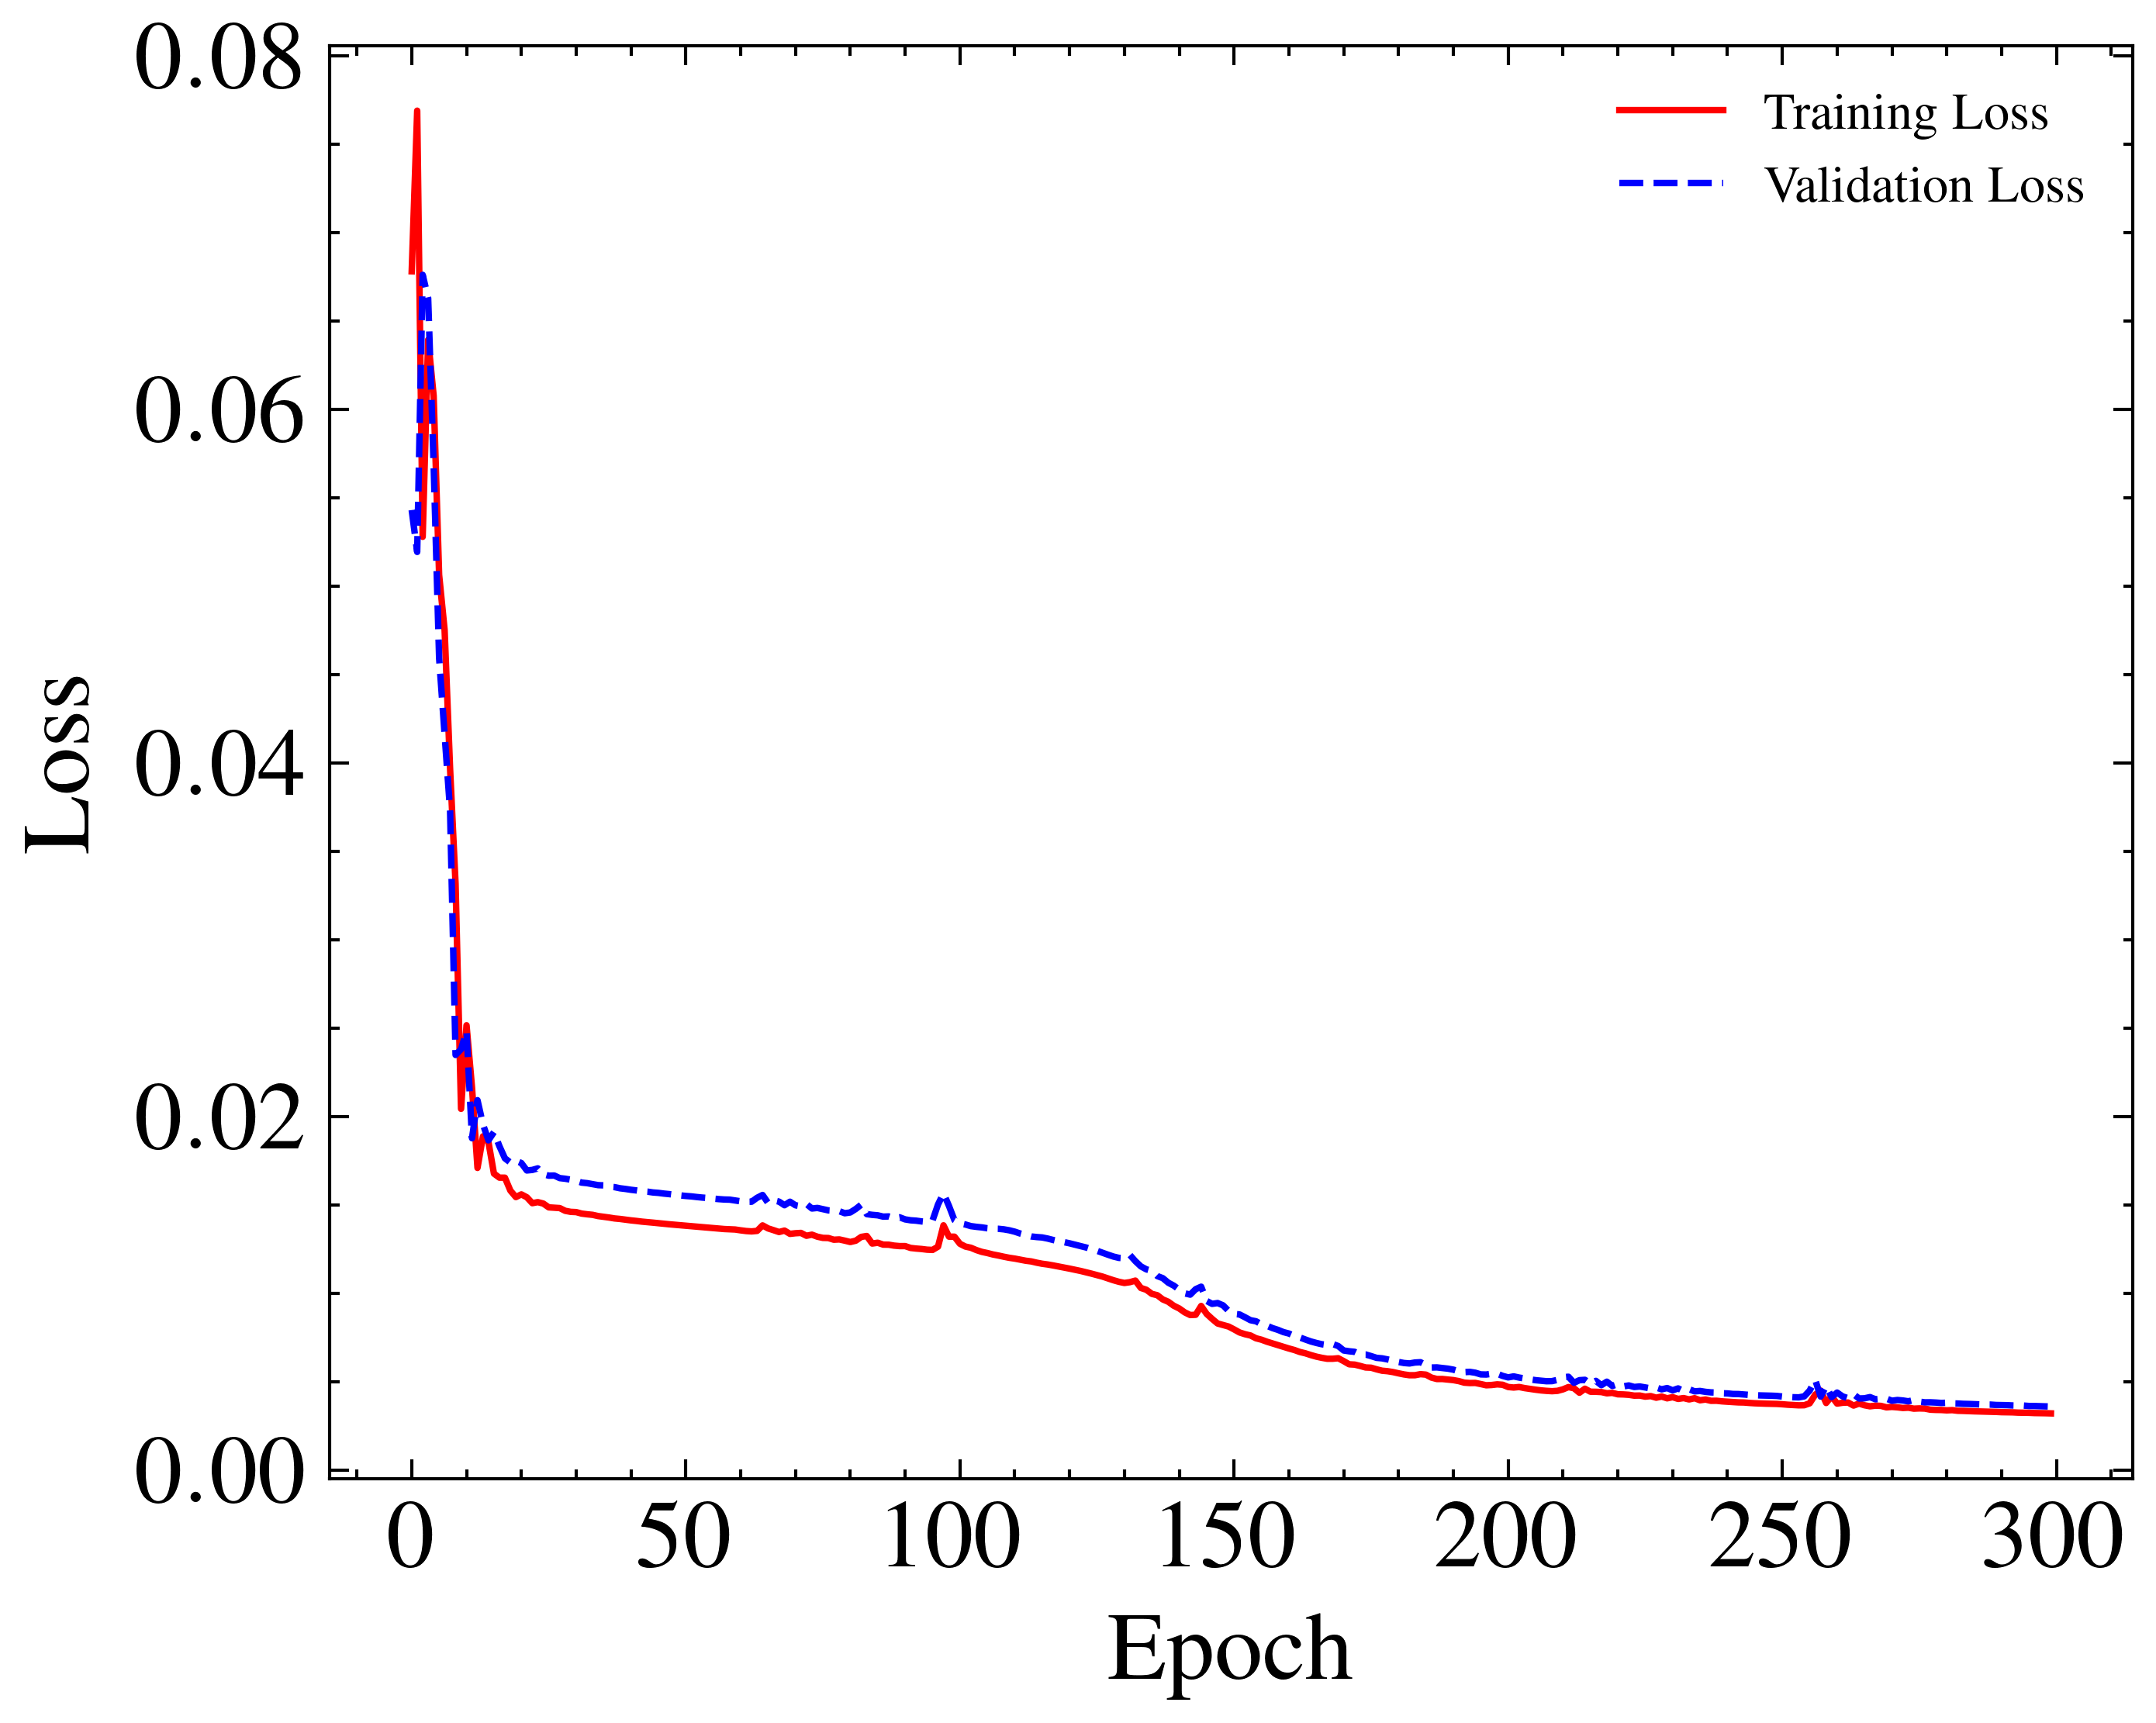

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots


# 配置绘图样式和参数
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = True
plt.style.use(['science', 'ieee'])
plt.rcParams['text.usetex'] = True

# 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()  # 清除现有内容
plt.tick_params(labelsize=15)  # 设置刻度字体大小

# 绘制损失曲线（红色和蓝色）
ax.plot(np.arange(len(train_loss)), train_loss, color='red', label='Training Loss', linewidth=1)
ax.plot(np.arange(len(valid_loss)), valid_loss, color='blue', label='Validation Loss', linewidth=1)

# 设置正体的轴标签
ax.set_xlabel(r'$\mathrm{Epoch}$', fontsize=15)
ax.set_ylabel(r'$\mathrm{Loss}$', fontsize=15)

# 手动设置x轴刻度
plt.xticks(np.arange(0, len(train_loss) + 5, step=50))

# 添加图例（标注）
plt.legend(fontsize=8, loc='upper right')

# 指定保存路径和文件名
plot_path = r'D:\PycharmProjects\保存的参数\指纹参数\loss_data（relu内嵌）.pkl'
# 保存为 EPS 文件
plt.savefig(plot_path, format='eps', bbox_inches='tight')
print(f"损失图已保存到 {plot_path}")

# 展示损失图
plt.show()

所有图像已保存至: ./relu（内嵌）Pics/


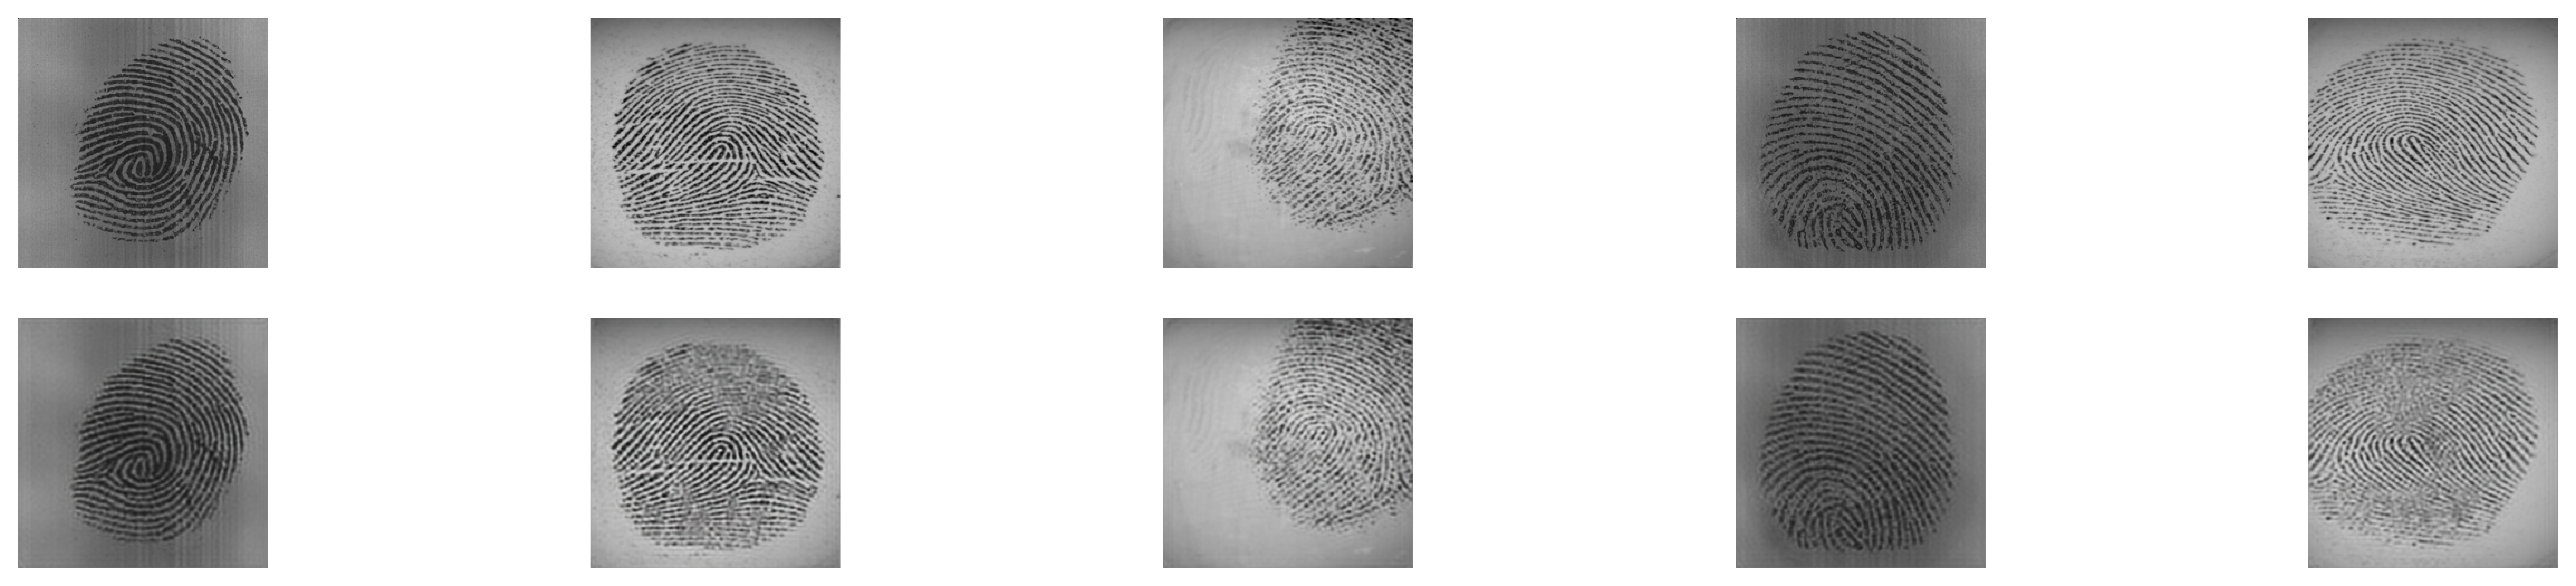

In [9]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


def save_and_visualize_reconstructions(model, data_loader, save_dir):
    """
    将所有验证集图像的原始和重建图像保存到指定文件夹，并展示前 5 张的对比。
    参数：
    - model: Autoencoder 模型
    - data_loader: 验证集的数据加载器
    - save_dir: 保存图像的文件夹路径（你需要提前创建好）
    """
    # 切换到评估模式
    model.eval()
    os.makedirs(save_dir, exist_ok=True)  # 如果文件夹不存在则创建
    img_counter = 0  # 图像计数器

    with torch.no_grad():
        # 遍历验证集批次
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            # 将张量转换为 NumPy 格式，并缩放到 [0, 255]
            inputs = (inputs.cpu().numpy() * 255).astype(np.uint8)
            outputs = (outputs.cpu().numpy() * 255).astype(np.uint8)

            # 遍历批次中的每一张图像
            for i in range(inputs.shape[0]):
                # 转换为 (H, W, C) 格式（适用于 PIL）
                original_img = np.transpose(inputs[i], (1, 2, 0))
                reconstructed_img = np.transpose(outputs[i], (1, 2, 0))

                # 保存原始和重建图像
                original_path = os.path.join(save_dir, f"original_{img_counter}.png")
                reconstructed_path = os.path.join(save_dir, f"reconstructed_{img_counter}.png")

                Image.fromarray(original_img).save(original_path)
                Image.fromarray(reconstructed_img).save(reconstructed_path)

                img_counter += 1  # 更新计数器

    print(f"所有图像已保存至: {save_dir}")

    # 展示前 5 张原始和重建图像的对比
    plt.figure(figsize=(20, 4))
    for i in range(5):
        # 加载已保存的图像
        original_img = Image.open(os.path.join(save_dir, f"original_{i}.png"))
        reconstructed_img = Image.open(os.path.join(save_dir, f"reconstructed_{i}.png"))

        # 显示原始图像
        plt.subplot(2, 5, i + 1)
        plt.imshow(original_img)
        plt.axis('off')

        # 显示重建图像
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed_img)
        plt.axis('off')

    plt.show()


# 使用你指定的文件夹路径保存和展示重建图像
save_dir =  "./relu（内嵌）Pics/"  # 将此处替换为你创建的文件夹路径
save_and_visualize_reconstructions(autoencoder, valid_loader, save_dir)